In [6]:
import time
import datetime
time.time()
int(time.time())
finish=datetime.datetime.now(datetime.timezone.utc)
finish



datetime.datetime(2017, 9, 26, 19, 9, 45, 502420, tzinfo=datetime.timezone.utc)

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from PIL import Image

%matplotlib inline

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

Starting calibration...


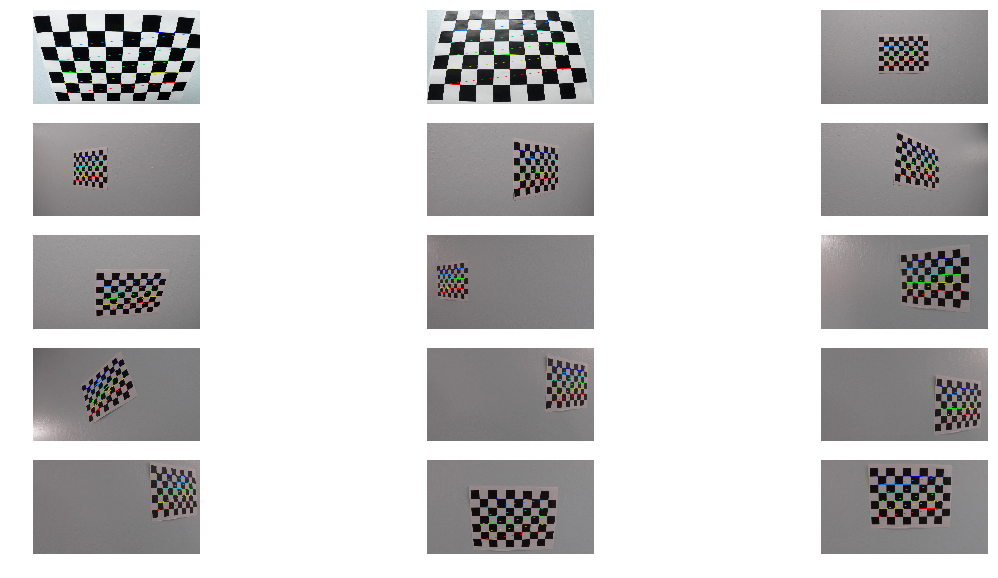

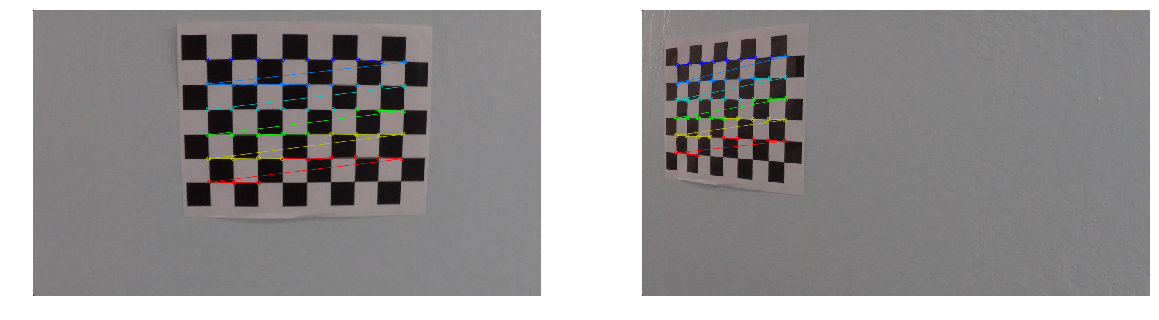

In [2]:
# Calibrate camera
from tqdm import tqdm
%matplotlib inline

def read_image_file(path):
    img = mpimg.imread(path)
    
    return img

def display_image(image, gray=False):
    plt.figure()
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show ()
def display_grid_images (images, grid_size, cell_size=(10, 10), cmap=None, titles=None):
    sizex, sizey = grid_size[0], grid_size[1]
    fig, imtable = plt.subplots (sizey, sizex, figsize=cell_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx=i+j*sizex
            if (isinstance(cmap,(list, tuple))):
                imtable[j][i].imshow(images[im_idx], cmap=cmap[i])
            else:
                im=images[im_idx]
                if len(im.shape) == 3:
                    imtable[j][i].imshow(im)
                else:
                    imtable[j][i].imshow(im, cmap='gray')
            imtable[j][i].axis('off')
            if not titles is None:
                channels = str(images[im_idx].shape)
                imtable[j][i].set_title(titles[im_idx]+" "+channels, fontsize=20)
                
    plt.show ()
    
def calibrate_camera(images, chess_rows, chess_cols):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chess_rows*chess_cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:chess_cols, 0:chess_rows].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images

    # Step through the list and search for chessboard corners
    calibrated_images = []

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (8,6), corners, ret)
            write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            calibrated_images.append(img)
        
    return calibrated_images, objpoints, imgpoints

images_names = glob.glob('camera_cal/cali*.jpg')
print("Starting calibration...")
calibrated_images,objpoints, imgpoints = calibrate_camera(images_names, 6, 9)
display_grid_images(calibrated_images, (3, 5), cell_size=(20, 10))
display_grid_images(calibrated_images[-3:], (2, 1), cell_size=(20, 10))

## Calculate distortion coefficient

Initiating distortion correction...
Calibrating...


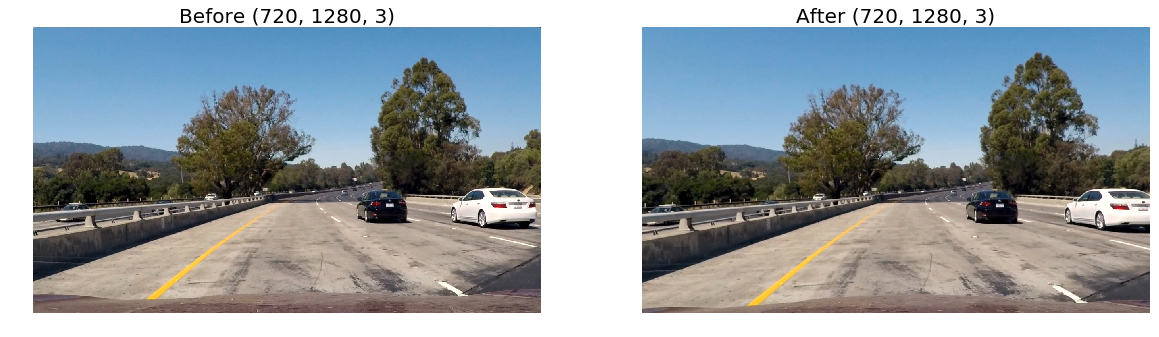

In [26]:
# Correct distortion

# Test undistortion on an image
print('Initiating distortion correction...')
img = cv2.imread('camera_cal/calibration03.jpg')
img = read_image_file('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
print('Calibrating...')
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
dst2 = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
cv2.imwrite('calibration_wide/test_undist.jpg',dst2)


display_grid_images([img, dst], (2, 1), cell_size=(20, 10), titles=('Before', 'After'))

## Testing the undistortion

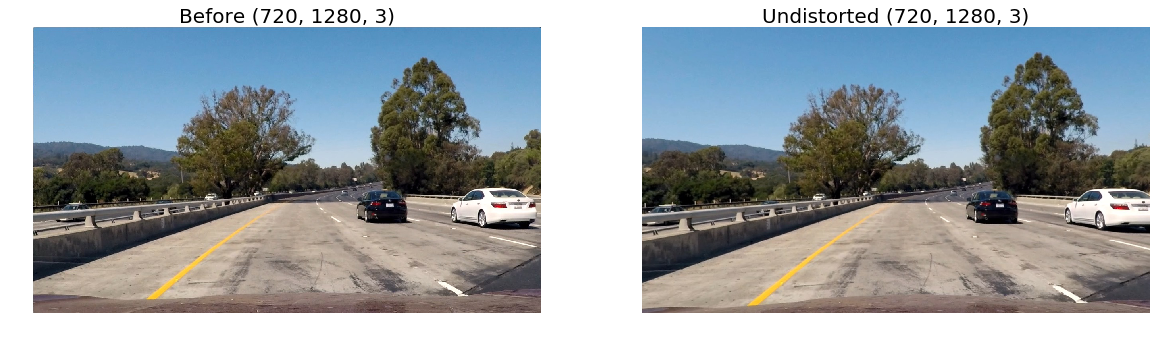

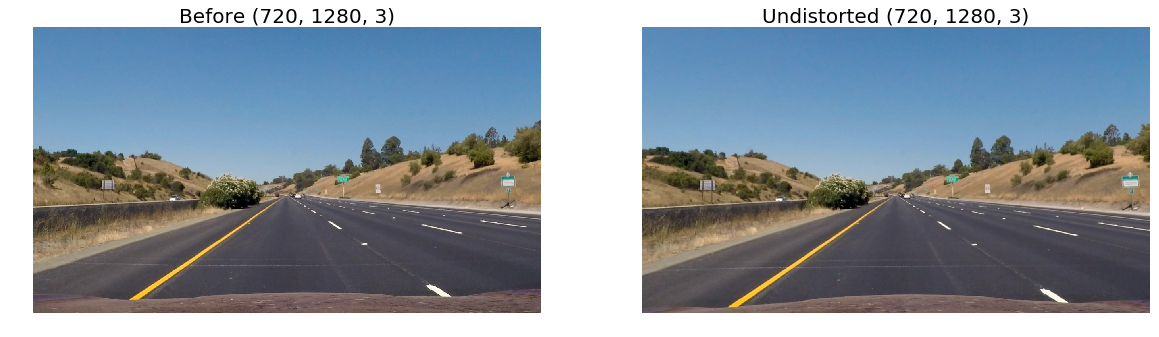

In [35]:
def undistort_image(img, camera_matrix, distortion_coeffs):
    img = cv2.undistort(img, camera_matrix, distortion_coeffs, None, camera_matrix)
    return img

def define_perspective_points(img):
    w, h = img.shape[1], img.shape[0]
    src_pts = np.float32([[(w/2)-55, (h/2) + 100],[(w/6)-10, h],[(w*5/6)+60, h],[(w/2)+55, (h/2) + 100]])
    dst_pts = np.float32([[w/4, 0],[w/4, h],[w*3/4, h],[w*3/4, 0]])
    return src_pts, dst_pts

img = read_image_file('test_images/test1.jpg')
undistorted_img = undistort_image(img, mtx, dist)
display_grid_images([img, undistorted_img], (2, 1), cell_size=(20, 10), titles=('Before', 'Undistorted'))

img = read_image_file('test_images/straight_lines1.jpg')
undistorted_img = undistort_image(img, mtx, dist)
display_grid_images([img, undistorted_img], (2, 1), cell_size=(20, 10), titles=('Before', 'Undistorted'))


## Testing Threshold Filters

In [86]:
# Function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient, sobel_kernel, grad_thresh):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= grad_thresh[0]) & (scaled_sobel <= grad_thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

# Function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel, mgn_thresh):
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobel = np.sqrt(np.square(np.absolute(sobelx))+np.square(np.absolute(sobely)))
    #Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mgn_thresh[0]) & (scaled_sobel <= mgn_thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

# Function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel, d_thresh):  
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    #Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    #Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    #Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction > d_thresh[0]) & (direction < d_thresh[1])] = 1
    #Return this mask as your binary_output image
    return binary_output

def LUV_thresh(img, l_thresh):
    img = np.copy(img) 
    height, width = img.shape[0], img.shape[1]

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV).astype(np.float)
    L = LUV[:,:,0]
    
    l_binary = np.zeros_like(L)
    l_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1
    return l_binary

def LAB_thresh(img, b_thresh):
    img = np.copy(img) 
    height, width = img.shape[0], img.shape[1]
    
    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    B = LAB[:,:,2]
    
    b_binary = np.zeros_like(B)
    b_binary[(B > b_thresh[0]) & (B <= b_thresh[1])] = 1
    return b_binary

def HLS_thresh(img, s_thresh):
    img = np.copy(img) 
    height, width = img.shape[0], img.shape[1]
    
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    S = HLS[:,:,2]
    
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    return s_binary

def HSV_thresh(img, v_thresh):
    img = np.copy(img) 
    height, width = img.shape[0], img.shape[1]
    
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    V = HSV[:,:,2]
    
    v_binary = np.zeros_like(V)
    v_binary[(V > v_thresh[0]) & (V <= v_thresh[1])] = 1 
    return v_binary

def R_G_thresh(img, color_thresh):
    img = np.copy(img) 
    height, width = img.shape[0], img.shape[1]
    
    R = img[:,:,0]
    G = img[:,:,1]
    
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_thresh) & (G > color_thresh)

def color_thresh_combined(img, s_thresh, l_thresh, v_thresh, b_thresh):
    V_binary = HSV_thresh(img, v_thresh)
    S_binary = HLS_thresh(img, s_thresh)
    L_binary = LUV_thresh(img, l_thresh)
    
    color_binary = np.zeros_like(V_binary)                           
    color_binary[(V_binary == 1) & (S_binary == 1) & (L_binary == 1)] = 1
    #color_binary[(V_binary == 1) & (S_binary == 1) & (B_binary == 1) & (L_binary == 1)] = 1

    return color_binary

def combine_thresholds(img, s_thresh, l_thresh, v_thresh, b_thresh, 
                                    gradx_thresh, grady_thresh, magn_thresh, 
                                    d_thresh, ksize):
    
    img = np.copy(img) 
    height, width = img.shape[0], img.shape[1]
    
    binary_x = abs_sobel_thresh(img, 'x', ksize, gradx_thresh)
    binary_y = abs_sobel_thresh(img, 'y', ksize, grady_thresh)
    mag_binary = mag_thresh(img, ksize, magn_thresh)    
    dir_binary = dir_thresh(img, ksize, d_thresh)
    color_binary = color_thresh_combined(img, s_thresh, l_thresh, v_thresh, b_thresh)
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    binary_output = np.zeros_like(img)
    binary_output[((binary_x == 1) & (binary_y == 1) & (mag_binary == 1)) | 
                  (color_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))
                 ] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(binary_output)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.4*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(binary_output, mask)
    
    return thresholded


## Color & Gradient thresholds

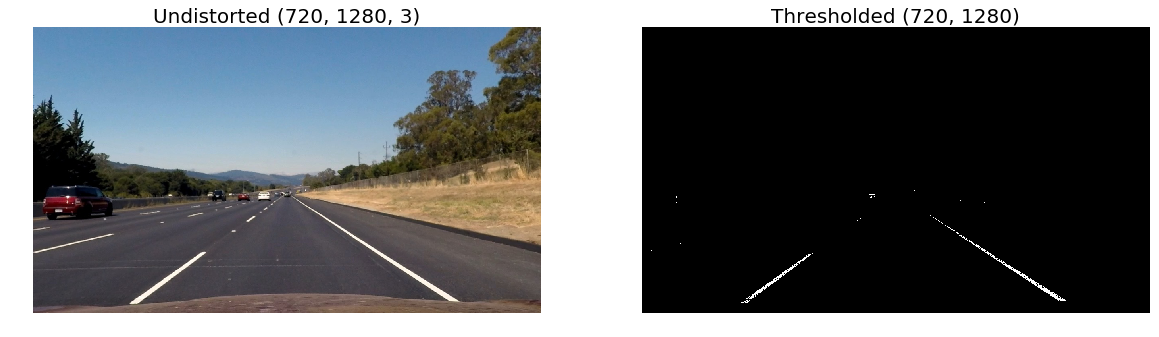

In [108]:
ksize = 13
color_thresh = 150
s_thresh=(200,255)
l_thresh = (200, 255)
v_thresh =(150, 255)
b_thresh =  (0,255)
gradx_thresh =(200, 255)
grady_thresh = (200, 255)
mgn_thresh=(100,255)
d_thresh = (np.pi/6, np.pi/2)

image = read_image_file('test_images/_straight_lines2.jpg') 
image = undistort_image(image, mtx, dist)

result =  color_thresh_combined(image, s_thresh, l_thresh, v_thresh, b_thresh)
display_grid_images([image, result], (2, 1), cell_size=(20, 10), 
                    titles=('Undistorted', 'Thresholded'))

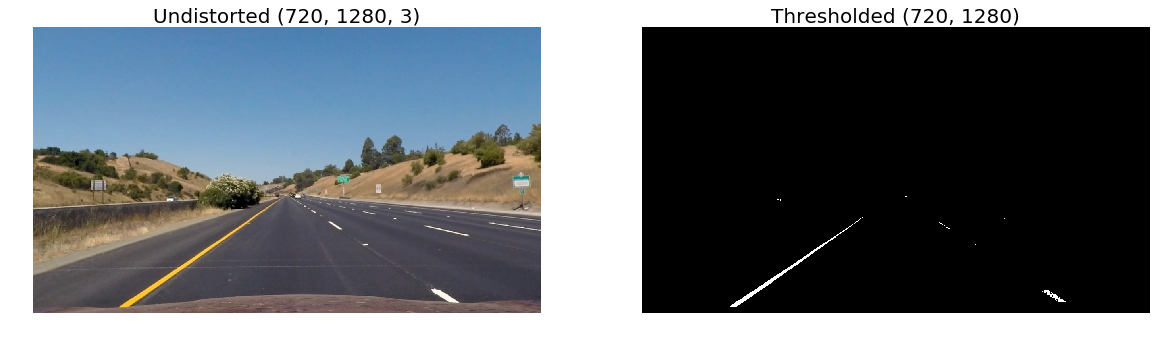

In [98]:
# Color & Gradient thresholds
image = read_image_file('test_images/straight_lines1.jpg')   
image = undistort_image(image, mtx, dist)

result =  color_thresh_combined(image, s_thresh, l_thresh, v_thresh, b_thresh)
display_grid_images([image, result], (2, 1), cell_size=(20, 10), 
                    titles=('Undistorted', 'Thresholded'))

## Functions for pipeline

In [99]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def perspective_transformation(img, src_pts, dst_pts, preview_lines=True):
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    if preview_lines:
        cv2.polylines(img, np.int32([src_pts]),True,(255,0,0), 4)
        cv2.polylines(img, np.int32([dst_pts]),True,(0,0,255), 4)
    return cv2.warpPerspective(img, matrix, dsize=img_size, flags = cv2.INTER_LINEAR)
    
def column_histogram(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)

def invert_perspective(img, src_pts, dst_pts):
    inv_matrix = cv2.getPerspectiveTransform(dst_pts, src_pts)
    result = cv2.warpPerspective(img, inv_matrix, dsize=img_size, flags = cv2.INTER_LINEAR)
    return inv_matrix, result

def radius_curvature(ploty, left_fitx, right_fitx, shape):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    mean_curverad = round(np.mean([left_curverad, right_curverad]), 2)
    
    # Find vehicle position
    frame_center_pixels = shape[1]/2
    camera_position_pixels = ((left_fitx[-1]+right_fitx[-1])/2)
    center_offset_meters = (camera_position_pixels - frame_center_pixels)*xm_per_pix


    return mean_curverad, center_offset_meters

In [100]:
def find_lines(binary):

    binary_warped = np.copy(binary)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    plt.plot(histogram)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 20
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,255), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    #Visualization
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Get curvature values and text to superimpose on frame
    mean_curverad, position =  radius_curvature(ploty, left_fitx, right_fitx, window_img.shape)
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return left_fit, right_fit, result, mean_curverad, position

In [101]:
import time, os, fnmatch, shutil

def superimpose_lane_area(img, warp_img, l_fit, r_fit, inv_matrix, mean_curverad, position):    
    height,width = img.shape[0],img.shape[1]
        
    ploty = np.linspace(0, height-1, num=height)
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Prepare x, y points into cv2.fillPoly() format
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Fill the lane region on lane_area
    lane_area =  np.zeros_like(img).astype(np.uint8)
    cv2.fillPoly(lane_area, np.int_([pts]), (0,200,0))
    cv2.polylines(lane_area, np.int32([pts_left]), isClosed=False, color=(255,20,147), thickness=15)
    cv2.polylines(lane_area, np.int32([pts_right]), isClosed=False, color=(255,20,147), thickness=15)
        
    # Warp the filled lane back to original image space using inverse perspective matrix
    new_warp = cv2.warpPerspective(lane_area, inv_matrix, (width, height)) 
    
    # Superimpose on the original image
    result = cv2.addWeighted(img, 1, new_warp, 0.3, 0)
    curv_text = "Mean radius of lane curvature: " + '{:6.2f}'.format(mean_curverad)
    center_text = 'Position: ' + '{:6.2f}'.format(position) + ' m'
    cv2.putText(result, curv_text,(30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255, 255, 255), 3)
    cv2.putText(result, center_text,(30, 180), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255, 255, 255), 3)
    t = time.localtime()
    timestamp = time.strftime('%b %d %Y %H:%M', t)
    cv2.putText(result, timestamp,(30, 280), cv2.FONT_HERSHEY_SIMPLEX, .9, (255, 255, 255), 3)

    return result

## Pipeline for single images
This pipeline will perform the sliding window from scratch for every image

./test_images/test1.jpg


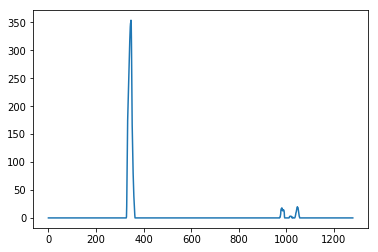

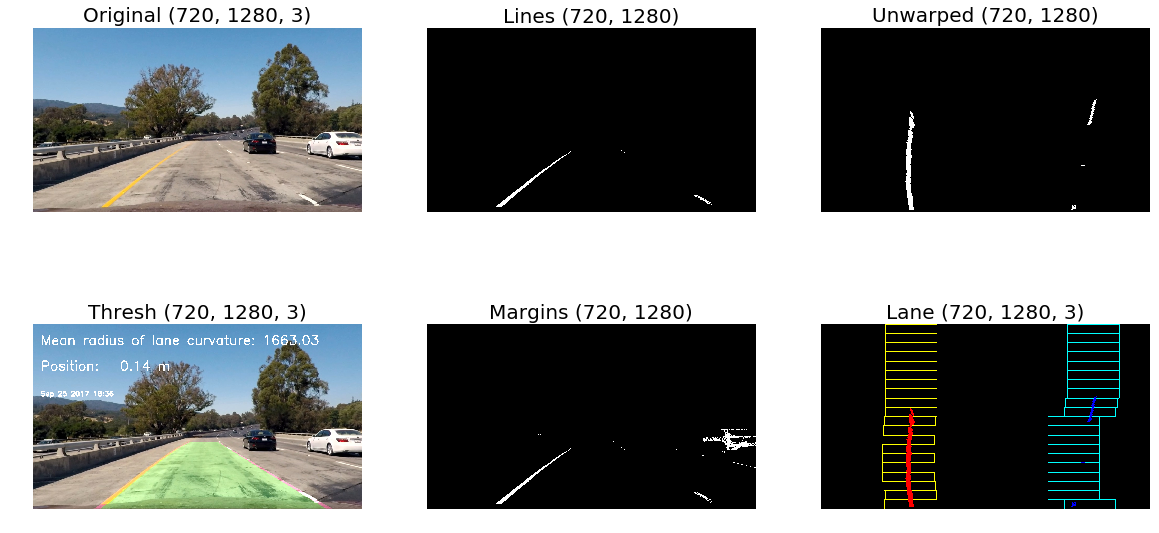

---------------------------------------------------------------------------------
./test_images/test2.jpg


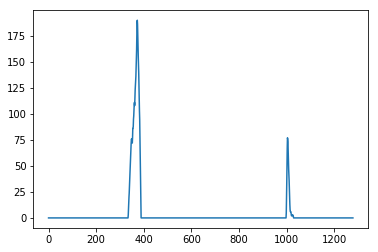

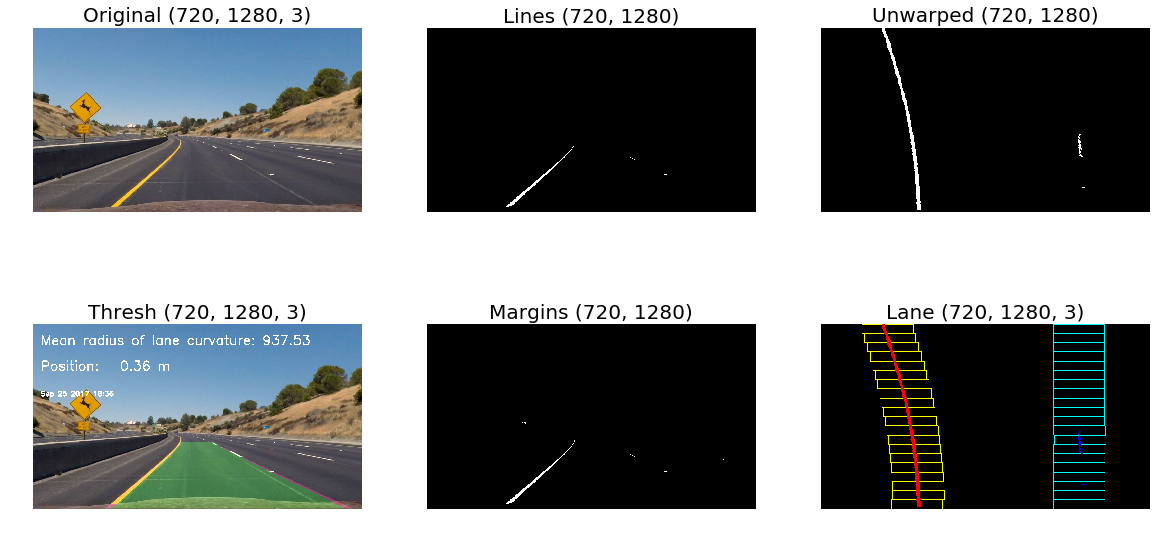

---------------------------------------------------------------------------------
./test_images/test3.jpg


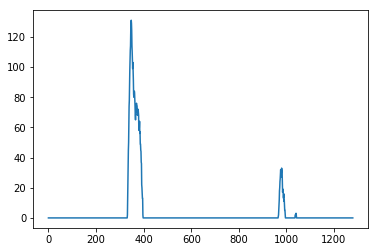

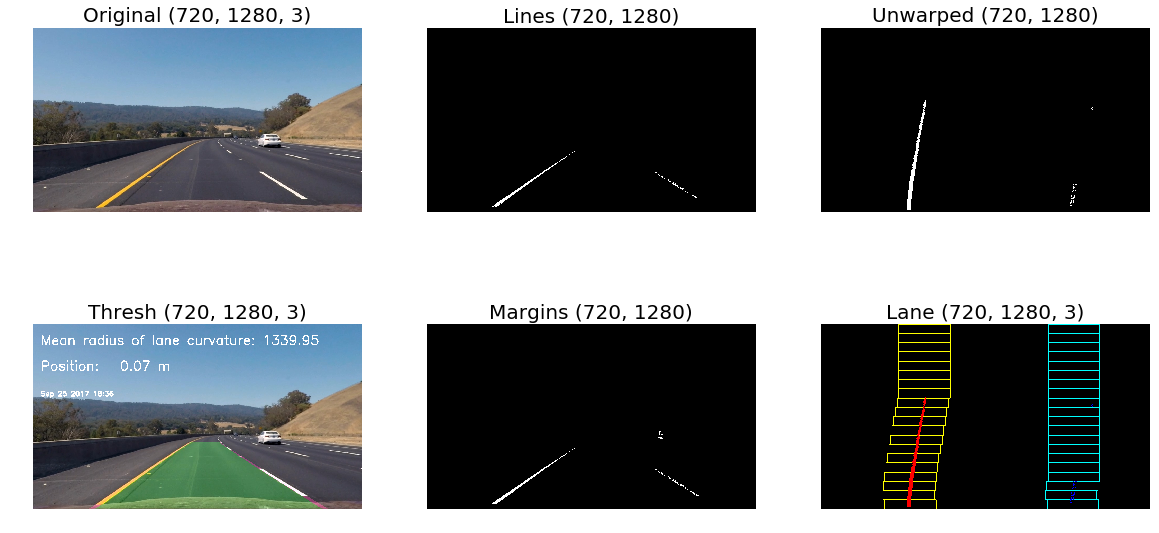

---------------------------------------------------------------------------------
./test_images/test4.jpg


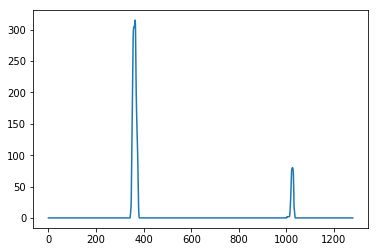

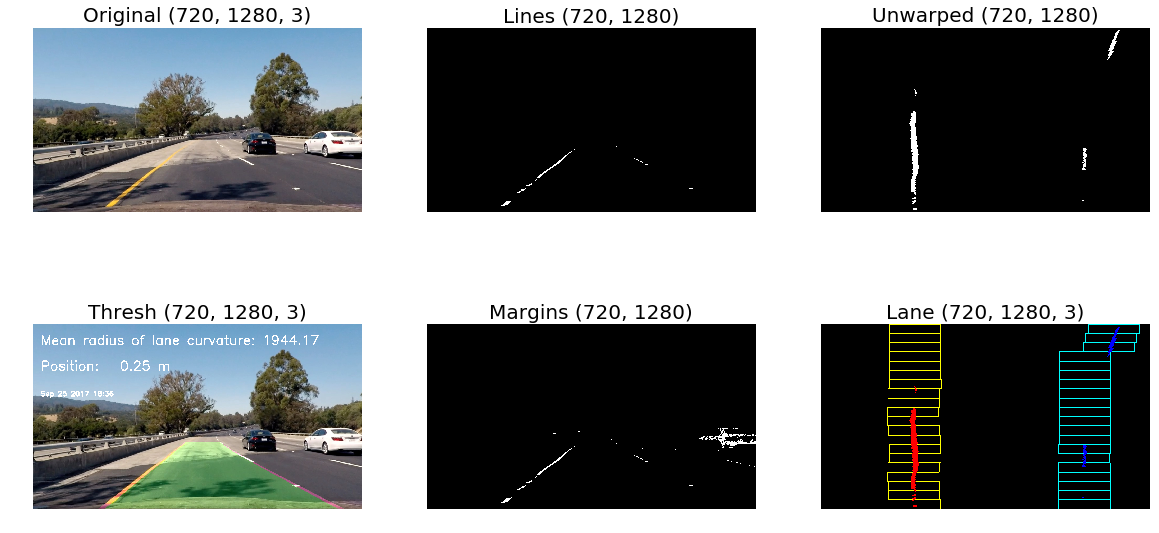

---------------------------------------------------------------------------------
./test_images/test5.jpg


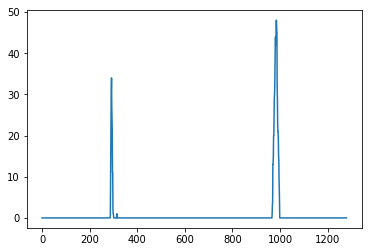

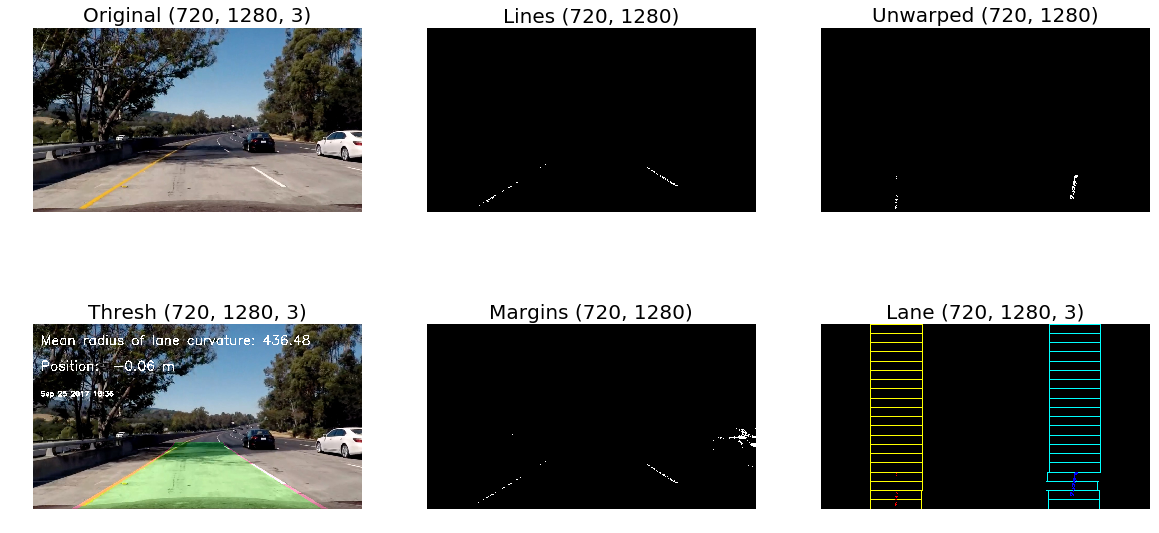

---------------------------------------------------------------------------------
./test_images/test6.jpg


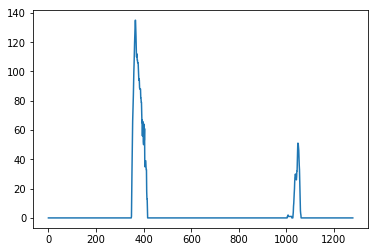

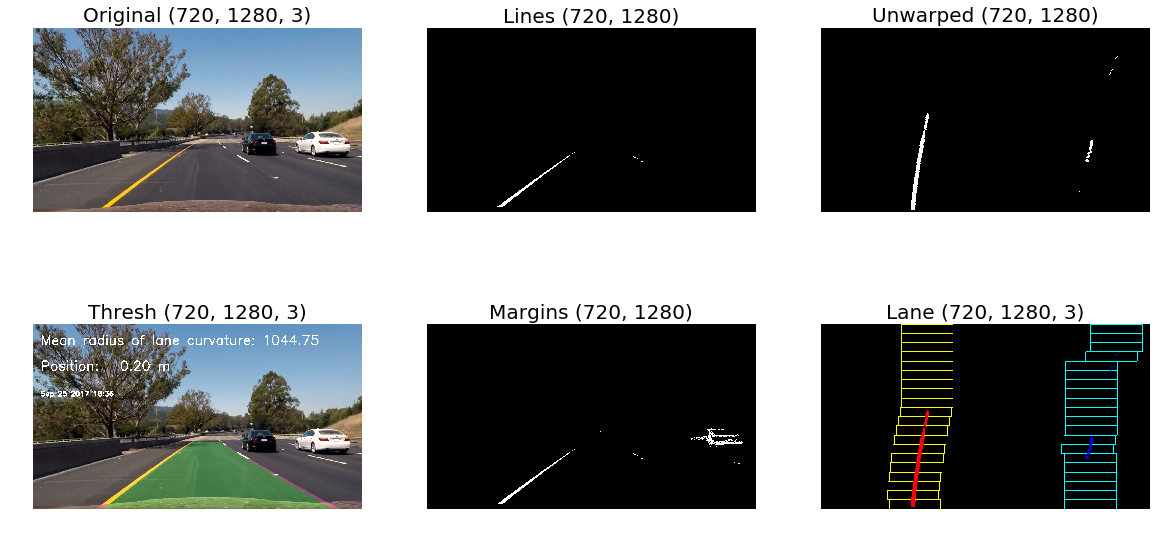

---------------------------------------------------------------------------------


In [102]:
images = glob.glob('./test_images/test*.jpg')



for idx, fname in enumerate(images):
    source_img = read_image_file(fname)
    print(fname)
    src_pts, dst_pts = define_perspective_points(source_img)
    source_img = undistort_image(source_img, mtx, dist)

    #thresh_img = combine_thresholds(source_img, s_thresh, l_thresh, v_thresh, b_thresh, 
    #                                gradx_thresh, grady_thresh, magn_thresh, 
    #                                d_thresh, ksize)
    thresh_img = color_thresh_combined(source_img, s_thresh, l_thresh, v_thresh, b_thresh)
    warp_img = perspective_transformation(thresh_img, src_pts, dst_pts, False)
    
    left_fit, right_fit, lines_img, mean_curverad, position = find_lines(warp_img)
    inv_matrix, unwarp_img = invert_perspective(warp_img, src_pts, dst_pts)
    
    lane_img = superimpose_lane_area(source_img, warp_img, left_fit, right_fit, inv_matrix, mean_curverad, position)
    
    display_grid_images([source_img, unwarp_img, warp_img, lane_img, thresh_img, lines_img], (3,2), cell_size=(20, 10), titles=('Original', 'Lines', 'Unwarped','Thresh','Margins','Lane'))
    print("---------------------------------------------------------------------------------")


# Solution for video
We'll modify the pipeline to consider when a previous frame has already found the lane area.

In [12]:
# Compute the moving average of the N previous lines
def get_averaged_line(previous_lines, new_line):

    frames_to_average = 10

    if new_line is None:        
        if len(previous_lines) == 0:
            new_line = None
        else:
            new_line = previous_lines[-1]
    else:
        if len(previous_lines) < frames_to_average:
            previous_lines.append(new_line)
        else:
            # shift-right list
            previous_lines[0:frames_to_average-1] = previous_lines[1:]
            previous_lines[frames_to_average-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(frames_to_average):
                new_line += previous_lines[i]
            new_line /= (frames_to_average)            
        
    return previous_lines, new_line

In [13]:
def find_lines_video(binary_warped):
    
    global first_frame_processed
    global left_fit, right_fit
    global previous_average_left, previous_average_right
    global last_average_left_fit, last_average_right_fit
    
    margin = 100

    if not first_frame_processed:
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 20
        # Set the width of the windows +/- margin
        # Set minimum number of pixels found to recenter window
        minpix = 100

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        first_frame_processed = True
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each

    if(lefty.size == 0 or leftx.size == 0 or rightx.size == 0 or righty.size == 0):
        left_fit = last_average_left_fit
        right_fit = last_average_right_fit
        first_frame_processed = False
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        previous_average_left, last_average_left_fit = get_averaged_line(previous_average_left, left_fit)
        previous_average_right, last_average_right_fit = get_averaged_line(previous_average_right, right_fit)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Get curvature values and text to superimpose on frame
    mean_curverad, position =  radius_curvature(ploty, left_fitx, right_fitx, window_img.shape)
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return left_fit, right_fit, result, mean_curverad, position

In [103]:
def save_frame(idx, basename, img):
# Auxiliary function to analyze frames that crashed the pipeline
    write_name = './frames/'+basename+'/'+basename+str(idx)+'.jpg'
    if basename != 'thresh':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(write_name, img)
    
def video_pipeline(source_img):
    global iidx
    src_pts, dst_pts = define_perspective_points(source_img)
    source_img = undistort_image(source_img, mtx, dist)

    #thresh_img = combine_thresholds(source_img, s_thresh, l_thresh, v_thresh, b_thresh, gradx_thresh, grady_thresh, magn_thresh, d_thresh, ksize)
    thresh_img = color_thresh_combined(source_img, s_thresh, l_thresh, v_thresh, b_thresh)

    warp_img = perspective_transformation(thresh_img, src_pts, dst_pts, False)
    
    left_fit_, right_fit_, lines_img, mean_curverad, position = find_lines_video(warp_img)

    inv_matrix, unwarp_img = invert_perspective(warp_img, src_pts, dst_pts)
    
    lane_img = superimpose_lane_area(source_img, warp_img, left_fit_, right_fit_, inv_matrix, mean_curverad, position)

    if iidx%10 == 0:
        save_frame(iidx,'source', source_img)
        save_frame(iidx, 'lane', lane_img)
    iidx += 1
    return lane_img



In [105]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
    
global first_frame_processed
global left_fit, right_fit
global previous_average_left, previous_average_right
global last_average_left_fit, last_average_right_fit
global iidx
iidx = 0
first_frame_processed = False
previous_average_left, previous_average_right = [], []

videos = glob.glob('project_video.mp4')
for idx, vname in enumerate(videos):
    video_output = './output_'+ vname
    clip = VideoFileClip(vname)
    out_clip = clip.fl_image(video_pipeline) 
    %time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_project_video.mp4
[MoviePy] Writing video ./output_project_video.mp4


100%|█████████▉| 1260/1261 [03:47<00:00,  5.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_project_video.mp4 

CPU times: user 5min 3s, sys: 39.2 s, total: 5min 42s
Wall time: 3min 48s


In [106]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))